In [0]:
!pip install quandl





     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 2.3MB 28.8MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=d3e912cc62cb823599a5bb91ecfbb9f54247df9196aa2766e1c3eb56c54ec534
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 8.0.2
    Uninstalling more-itertools-8.0.2:
      Successfully uninstalled more-itertools-8.0.2


cross_validation--- para crear nuestras muestras de capacitacion y prueba. Una forma de dividir los datos, para que no tengas una muestra sesgada y tambien ayuda a separar los datos 

svm--maquina vectores soporte

-"Para pronosticar, necesitamos algunos datos. Decidimos que pronosticamos el 10% de los datos, por lo tanto, desearemos, o al menos * podemos * generar pronósticos para cada uno del 10% final del conjunto de datos. Entonces, ¿cuándo podemos hacer esto? ¿Cuándo identificaremos esos datos? Podríamos llamarlo ahora, pero tenga en cuenta que los datos que estamos tratando de pronosticar no están escalados como lo hicieron los datos de entrenamiento. De acuerdo, ¿entonces qué? ¿Acabamos de hacer preprocessing.scale () contra el último 10%? El método de escala escala en función de todos los datos conocidos que se introducen en él. Idealmente, debería escalar todos los datos de capacitación, prueba y pronóstico / predicción. ¿Es esto siempre posible o razonable? No. Si puedes hacerlo, deberías, sin embargo. En nuestro caso, ahora mismo, podemos hacerlo. Nuestros datos son lo suficientemente pequeños y el tiempo de procesamiento es lo suficientemente bajo, por lo que preprocesaremos y escalaremos los datos de una vez.

En muchos casos, no podrá hacer esto. Imagínese si estuviera utilizando gigabytes de datos para entrenar a un clasificador. Puede llevar días entrenar a tu clasificador, no querrías hacerlo cada ... solo ... cada vez que quisieras hacer una predicción. Por lo tanto, es posible que NO deba escalar nada, o puede escalar los datos por separado. Como de costumbre, querrá probar ambas opciones y ver cuál es el mejor en su caso específico.

Con eso en mente, manejemos todas las filas desde la definición de X en adelante."

              Open    High     Low  ...   Adj. Low  Adj. Close  Adj. Volume
Date                                ...                                    
2004-08-19  100.01  104.06   95.96  ...  48.128568   50.322842   44659000.0
2004-08-20  101.01  109.08  100.50  ...  50.405597   54.322689   22834300.0
2004-08-23  110.76  113.48  109.05  ...  54.693835   54.869377   18256100.0
2004-08-24  111.24  111.60  103.57  ...  51.945350   52.597363   15247300.0
2004-08-25  104.76  108.00  103.88  ...  52.100830   53.164113    9188600.0

[5 rows x 12 columns]
            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.324968   44659000.0
2004-08-20   54.322689  7.921706    7.227007   22834300.0
2004-08-23   54.869377  4.049360   -1.227880   18256100.0
2004-08-24   52.597363  7.657099   -5.726357   15247300.0
2004-08-25   53.164113  3.886792    1.183658    9188600.0
Exactitud
0.9778962029466953


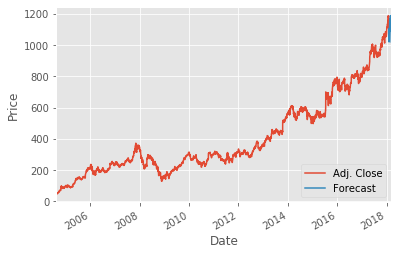

In [0]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import pickle 

style.use('ggplot')

df = quandl.get("WIKI/GOOGL")
print(df.head())
#print(df.tail())
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('Exactitud')
print(confidence)

#pickle_in = open('LinearRegression.pickle','rb')
#clf = pickle.load(pickle_in)

forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()